## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import locCSN

## 2. Load data 

In [2]:
adata = sc.read('PDAC.h5ad') 

In [3]:
adata

AnnData object with n_obs × n_vars = 57530 × 24005
    obs: 'cluster'

In [4]:
adata.obs.head()

,cluster
cell.name,
T1_AAACCTGAGATGTCGG,Fibroblast cell
T1_AAACGGGGTCATGCAT,Stellate cell
T1_AAAGATGCATGTTGAC,Macrophage cell
T1_AAAGATGGTCGAGTTT,Macrophage cell
T1_AAAGATGGTCTCTCTG,Endothelial cell


In [5]:
adata.var.head()

""
Unnamed: 0
AL627309.1
AP006222.2
RP11-206L10.3
RP11-206L10.2
RP11-206L10.9


In [6]:
adata.X.shape

(57530, 24005)

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

# we now have many additional data types in the obs slot:
adata

AnnData object with n_obs × n_vars = 57530 × 24005
    obs: 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

print(sum(mito_genes))

13


In [9]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)

103


In [10]:
adata

AnnData object with n_obs × n_vars = 57530 × 24005
    obs: 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

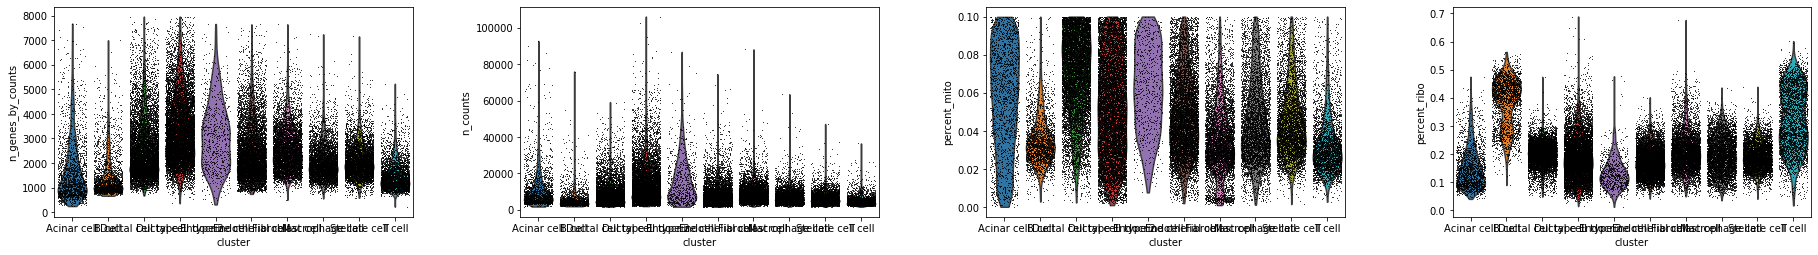

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'cluster')

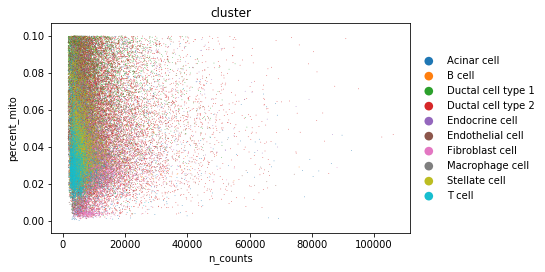

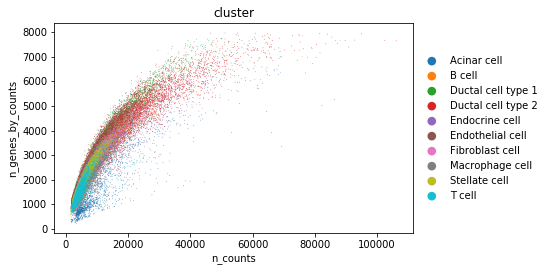

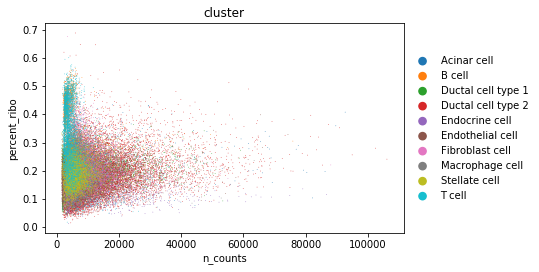

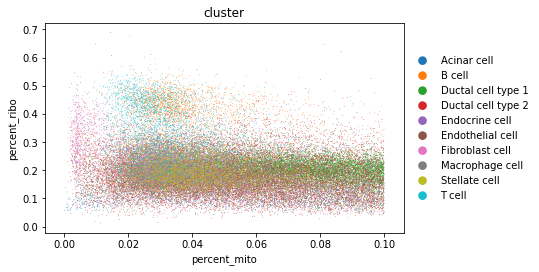

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color='cluster')
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color='cluster')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color='cluster')
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color='cluster')

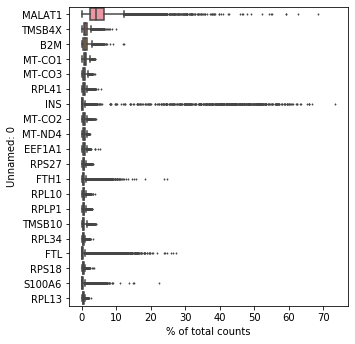

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

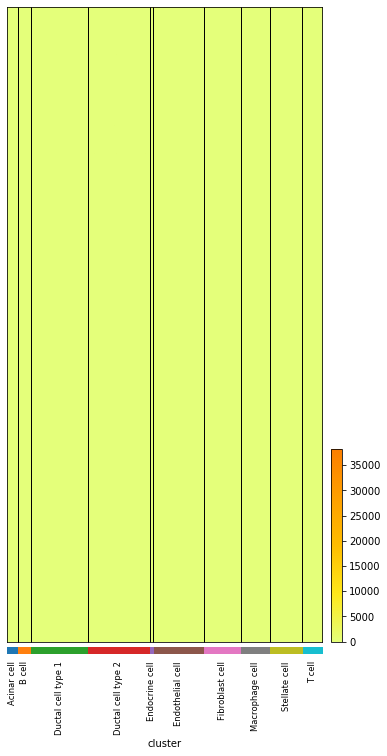

In [18]:
# Plot the Heatmap of gene expression
sc.pl.heatmap(adata, adata.var.index, groupby= "cluster", dendrogram = False, swap_axes = True 
            , cmap='Wistia', figsize=(6,12))

## PCA

In [22]:
adata_norm_pca = adata.copy()

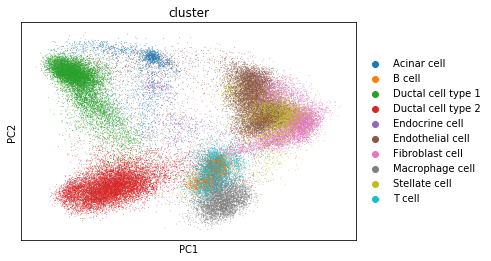

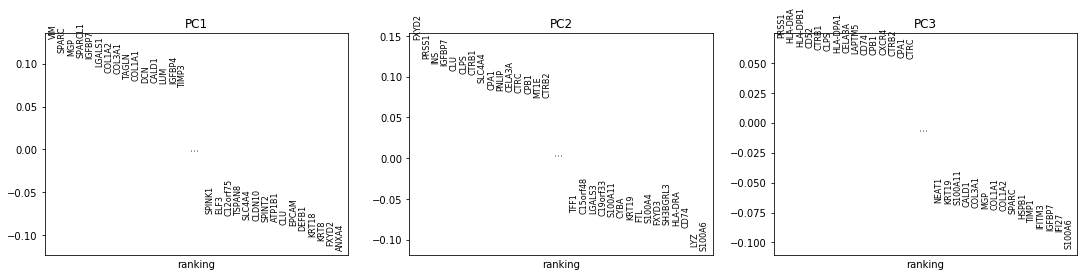

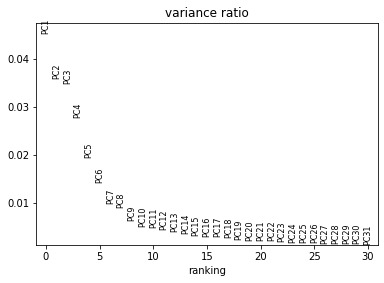

In [23]:
sc.pp.normalize_total(adata_norm_pca, inplace=True)
sc.pp.log1p(adata_norm_pca)
sc.pp.pca(adata_norm_pca)
sc.pl.pca_overview(adata_norm_pca, color='cluster')

## UMAP

In [24]:
adata_umap = adata.copy()

In [25]:
sc.pp.neighbors(adata_umap) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata_umap, random_state=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


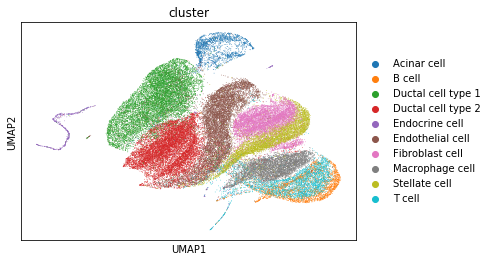

In [26]:
sc.pl.umap(adata_umap, color='cluster')

In [27]:
adata_pca_one = adata.copy() # apply this to a copy so we can compare methods
adata_pca_one.raw = adata_pca_one # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_pca_one, counts_per_cell_after=1e6)

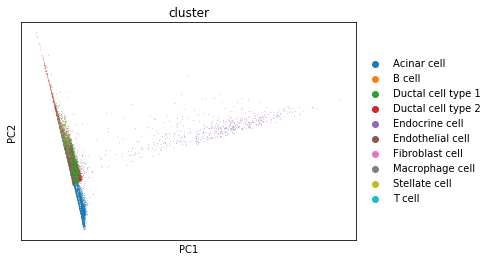

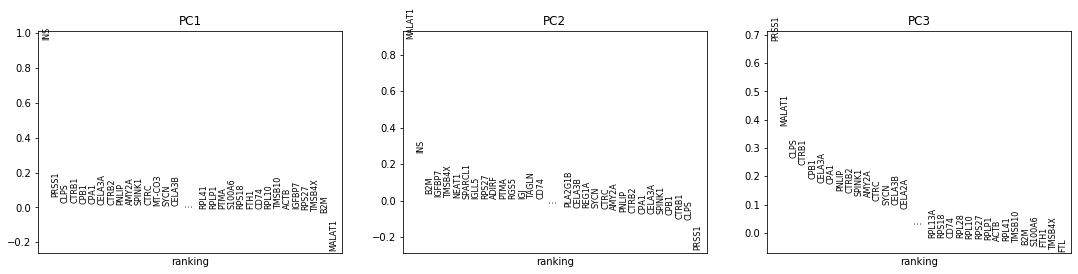

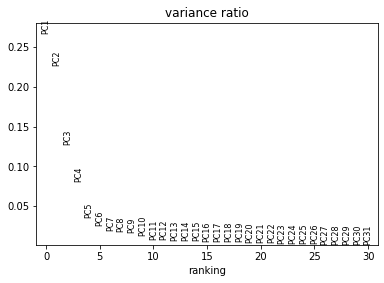

In [28]:
sc.pp.pca(adata_pca_one)
sc.pl.pca_overview(adata_pca_one, color='cluster')

## t-SNE

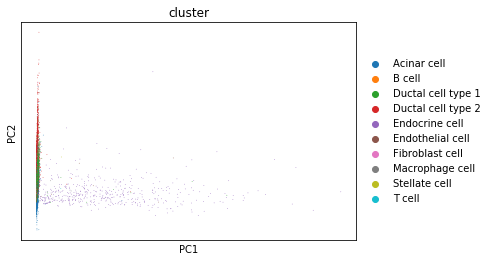

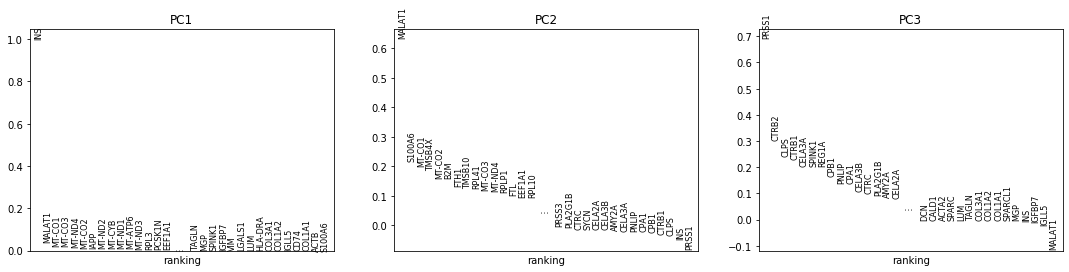

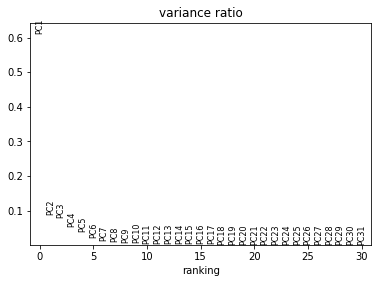

In [29]:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='cluster')

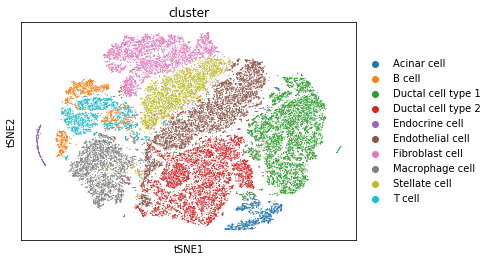

In [30]:
sc.tl.tsne(adata,random_state=42) 
sc.pl.tsne(adata, color='cluster')